# YouTube URL Analysis

## Preface
### Data descriptions

In [1]:
sample_size = 100000000 # specifies the sample size
#sample_size = 10000000
#sample_size = "all"
debug = True
extract_hosts = False
parallel = True
if sample_size > 10000000:
    parallel = False
limit = 15  # specifies the number of elements in lists and graphs
n_cores = 12 # number of cores to use for parallelization

url_columns = ["id", "hash", "channelId", "publishedAt", "url", "resolvedUrl", "domain","resolved","dead","status_code"]
video_columns = ["id","hash","channelId","channelTitle","publishedAt","title","description","tags","categoryId","defaultLanguage","defaultAudioLanguage","duration","dimension","definition","caption","licensedContent","allowedIn","blockedIn","viewCount","likeCount","dislikeCount","favoriteCount","commentCount","requesttime"]
channel_columns = ["id","title","description","subscriberCount","videoCount","commentCount","viewCount","featuring","subscribing","country","publishedAt","daysactive","keywords","topics","wikitopics"]

### Import necessary modules

In [2]:
import numpy as np
import pandas as pd
import csv
import datetime
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_theme(style="darkgrid")
sns.set(rc={'figure.figsize':(14,8.27)})
from multiprocessing import Pool
import os, gc
import re

### Load data

In [3]:
# load URLs csv
pd_url_data = pd.read_csv('sample_' + str(sample_size) + '.csv', names=url_columns)
if debug:
    pd_url_data.info(verbose=False, memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100000000 entries, 0 to 99999999
Columns: 10 entries, id to status_code
dtypes: float64(1), int64(3), object(6)
memory usage: 48.8 GB


In [4]:
# cast columns in right type
pd_url_data['date'] = pd.to_datetime(pd_url_data["publishedAt"]).dt.date
pd_url_data['year'] = pd.to_datetime(pd_url_data["publishedAt"]).dt.year

# skip everything before 1 december 2019
pd_url_data = pd_url_data[pd_url_data['date'] < datetime.date(year=2019, month=12, day=1)]
print("min date: %s, max date: %s\n" % (min(pd_url_data.date),max(pd_url_data.date)))

if debug:
    pd_url_data.info(verbose=False, memory_usage="deep")

min date: 2005-10-24, max date: 2019-11-30

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98835480 entries, 0 to 99999999
Columns: 12 entries, id to year
dtypes: float64(1), int64(4), object(7)
memory usage: 53.4 GB


In [5]:
# get rid of columns we don't need
pd_url_data = pd_url_data[["id", "hash", "channelId", "year", "resolvedUrl", "resolved", "dead"]]
if debug:
    pd_url_data.info(verbose=False, memory_usage="deep")

<class 'pandas.core.frame.DataFrame'>
Int64Index: 98835480 entries, 0 to 99999999
Columns: 7 entries, id to dead
dtypes: int64(4), object(3)
memory usage: 27.2 GB


### Check 'dead' URLs + how many have not yet been checked 

Info for full data set:
* 249.790 unique URLs are unresolved. They are all URLs that have a wrong format (either because of a parsing mistake, or because they were written as such in the video description). 
* when counting duplicates as well, this amounts to 4.709.688 URLs

3.66% dead
0.82% could NOT be resolved

In [6]:
# count URLs marked as dead on expansion
pd_url_data_dead = len(pd_url_data.query("dead==1"))
# count total number of URLs
total = len(pd_url_data)
# calculate percentage
percent_dead = round(pd_url_data_dead/total*100,2) 
# print percentage
print("Total URLS: %s, of which %s (%s%%) dead" % (total, pd_url_data_dead, percent_dead))

# unchecked if resolved = 0 and dead = 0
pd_url_data_unchecked = len(pd_url_data.query('resolved==0 & dead==0'))
percent_unchecked = round(pd_url_data_unchecked/total*100,2)
print("Total URLS: %s, of which %s (%s%%) could NOT be resolved" % (total, pd_url_data_unchecked, percent_unchecked))

# get rid of columns we don't need
pd_url_data = pd_url_data[["id", "hash", "channelId", "year","resolvedUrl"]]

# free up even more memory
del pd_url_data_dead
del pd_url_data_unchecked
gc.collect();

if debug:
    pd_url_data.info(verbose=False, memory_usage="deep")



Total URLS: 98835480, of which 3618363 (3.66%) dead
Total URLS: 98835480, of which 807823 (0.82%) could NOT be resolved
<class 'pandas.core.frame.DataFrame'>
Int64Index: 98835480 entries, 0 to 99999999
Columns: 5 entries, id to resolvedUrl
dtypes: int64(2), object(3)
memory usage: 25.7 GB


### Clean data

In [7]:
# load list of icann tlds and stlds
from icann_domains import icann_domains
pd_icann_domains = pd.Series(icann_domains)
pd_icann_domains_stld = pd_icann_domains[pd_icann_domains.str.contains("\.")]  # filter for second/third/... level tld
pd_icann_domains_stld = '.' + pd_icann_domains_stld.astype(str) # make sure we will filter on stld, rather than part of domain


In [8]:
# function that checks whether a URL ends with an icann stld and extracts proper host name
# @todo, super costly function. See whether it can be improved
def get_host(url):
    try:
        if url.endswith(tuple(pd_icann_domains_stld)): # check whether url ends in stld
            stld_found = next((stld for stld in pd_icann_domains_stld if url.endswith(str(stld))), None)  # find which stld it ends with
            if stld_found is not None:
                return re.sub(".*?([^.]+\\" + stld_found + ")$", r"\1", url)  # get host as non-dotted word before (and incl) stld
            else:
                return re.sub('.*?([^.]+\.[^.]+)$', r"\1", url)
        else:
            return re.sub('.*?([^.]+\.[^.]+)$', r"\1", url)
    except:
        return ''

def clean_data_wrapped(df):
    try:
        return clean_data(df)
    except:
        print("%s Except in clean_data_wrapped"%(now_string()))
        return False # @todo, warning this is just for testing!

def now_string():
    return datetime.datetime.now().strftime("%H:%M:%S")

# function to clean data: clean up URLs, remove slashes, extract host
def clean_data(df,dohost=True):
    if debug:
        print("%s pid child %s length = %s" % (now_string(), os.getpid(), len(df)))

    # remove trailing slash
    df.replace({'resolvedUrl': r'/\)?$'}, {'resolvedUrl':''}, regex=True, inplace=True)

    # override domain from URL extraction
    df['domain'] = df['resolvedUrl'].replace('https?://([^/:#]+).*', r'\1', regex=True)  # extract full domain (don't rely on extracted stuff in db)

    # lowercase all domains
    df['domain'] = df['domain'].str.lower()

    # remove all www. or www2.
    df.replace({'domain': r'^www2?\.'}, {'domain': ''}, regex=True, inplace=True)

    if debug:
        print("%s pid child %s cleaned URLs done"%(now_string(), os.getpid()))

    # replace common abbreviations
    df.replace({'domain': 'youtu.be'}, {'domain': 'youtube.com'}, regex=True, inplace=True)
    df.replace({'domain': 'fb.com'}, {'domain': 'facebook.com'}, regex=True, inplace=True)
    df.replace({'domain': 'm.facebook.com'}, {'domain': 'facebook.com'}, regex=True, inplace=True)
    # df.replace({'domain': r'^open\.spotify'}, {'domain': 'spotify'}, regex=True, inplace=True)

    if debug:
        print("%s pid child %s domain replacements done"%(now_string(), os.getpid()))    

    if extract_hosts:
        if dohost:
            # get host based on icann (s)tlds
            df['host'] = df['domain'].apply(get_host)

            if debug:
                print("%s pid child %s get hosts done"%(now_string(), os.getpid()))

    return df

# function to parallelize dataframe computation
def parallelize_dataframe(df, func, n_cores):
    
    if debug:
        df.info(verbose=False, memory_usage="deep")
    
    # split data frame
    df_split = np.array_split(df, n_cores)
    df = pd.DataFrame()
    
    if debug:
        df.info(verbose=False, memory_usage="deep")

    # start multi-processing
    pool = Pool(n_cores)
    df = pd.concat(pool.map(func, df_split))
    if debug:
        print("join length %s" % (len(df)))
    pool.close()
    pool.join()
    return df

if parallel:
    if debug:
        print("start length %s"%(len(pd_url_data)))
    pd_url_data = parallelize_dataframe(pd_url_data, clean_data_wrapped, n_cores)

else: # clean data: clean up URLs, remove slashes, extract host
    # remove trailing slash
    pd_url_data.replace({'resolvedUrl': r'/\)?$'}, {'resolvedUrl': ''}, regex = True, inplace = True)

    # override domain from URL extraction
    pd_url_data['domain'] = pd_url_data['resolvedUrl'].replace('https?://([^/:#]+).*', r'\1', regex=True)  # extract full domain (don't rely on extracted stuff in db)

    # remove all www. or www2.
    pd_url_data.replace({'domain': r'^www2?\.'}, {'domain': ''}, regex=True, inplace=True)

    # lowercase all domains
    pd_url_data['domain'] = pd_url_data['domain'].str.lower()

    if debug:
        print("%s cleaned URLs done"%(now_string()))

    # replace common abbreviations
    pd_url_data.replace({'domain': 'youtu.be'}, {'domain': 'youtube.com'}, regex=True, inplace=True)
    pd_url_data.replace({'domain': 'fb.com'}, {'domain': 'facebook.com'}, regex=True, inplace=True)
    pd_url_data.replace({'domain': 'm.facebook.com'}, {'domain': 'facebook.com'}, regex=True, inplace=True)
    # df.replace({'domain': r'^open\.spotify'}, {'domain': 'spotify'}, regex=True, inplace=True)

    if debug:
        print("%s domain replacements done"%(now_string()))    

    if extract_hosts:
        # get host based on icann (s)tlds
        pd_url_data['host'] = pd_url_data['domain'].apply(get_host)

        if debug:
            print("%s get hosts done"%(now_string()))

17:53:16 cleaned URLs done
17:58:51 domain replacements done


# Generic analysis

In [9]:
print("Basic stats on int/float columns")
with pd.option_context('display.precision', 2):
    display(pd_url_data.describe())

Basic stats on int/float columns


,id,year
count,9.88e+07,9.88e+07
mean,2.89e+08,2.02e+03
std,1.67e+08,2.01e+00
min,7.00e+00,2.00e+03
25%,1.44e+08,2.02e+03
50%,2.89e+08,2.02e+03
75%,4.33e+08,2.02e+03
max,5.78e+08,2.02e+03


## Basic stats (based on videos, not channels)

### Number of URLs per year

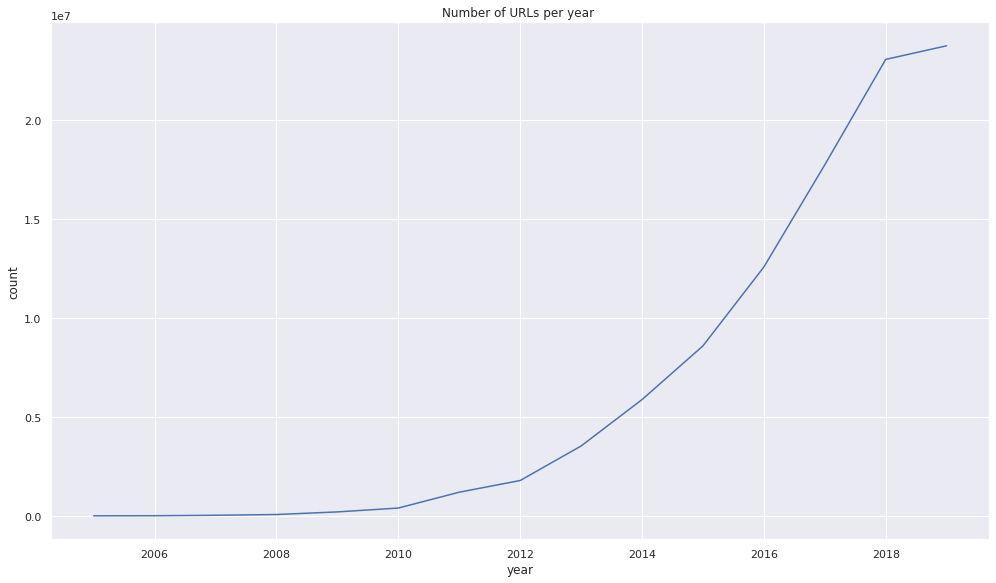

In [10]:
# count URL per year
pd_url_data['count'] = 1
pd_url_data_UrlsPerYear = pd_url_data.groupby(["year"]).count()['count'].reset_index()
# print(pd_url_data_UrlsPerYear)
# pd_url_data_videosWithUrlsPerYear = pd_url_data.groupby('year')['hash'].nunique().reset_index()
# print(pd_url_data_videosWithUrlsPerYear)

plt.figure()
sns.lineplot(x="year", y="count",markers=True, dashes=False, data=pd_url_data_UrlsPerYear)
plt.title("Number of URLs per year ")
plt.tight_layout()


### Channel and domain counts

In [11]:
# count unique videos for each channel
videoCountForChannel = pd_url_data.groupby('channelId')['hash'].nunique()
# add videoCountForChannel as column
pd_url_data['videoCountForChannel'] = pd_url_data['channelId'].map(videoCountForChannel)

# count unique videos for each domain
videoCountForDomain = pd_url_data.groupby('domain')['hash'].nunique()
# add videoCountForDomain as column
pd_url_data['videoCountForDomain'] = pd_url_data['domain'].map(videoCountForDomain)

# count unique channels for domain
channelCountForDomain = pd_url_data.groupby('domain')['channelId'].nunique()
# add channelCountForDomain as column
pd_url_data['channelCountForDomain'] = pd_url_data['domain'].map(channelCountForDomain)

# add channels/videos for domains
pd_url_data['channelDivVideoForDomain'] = round(pd_url_data['channelCountForDomain'] / pd_url_data['videoCountForDomain'] * 100, 3)

### Top domains

In [12]:
# reset count column
pd_url_data['count'] = 1 
# count domains in URLs data set and sort in reverse
pd_url_data_groupedDomain = pd_url_data.groupby(["domain"]).count()['count'].sort_values(ascending=False).reset_index()
# add diversity measure
pd_url_data_groupedDomain['videoCountForDomain'] = pd_url_data_groupedDomain['domain'].map(videoCountForDomain)
pd_url_data_groupedDomain['channelCountForDomain'] = pd_url_data_groupedDomain['domain'].map(channelCountForDomain)
pd_url_data_groupedDomain['channelDivVideoForDomain'] = pd_url_data_groupedDomain['channelCountForDomain'] / pd_url_data_groupedDomain['videoCountForDomain'] * 100

# print header
print("Top %s domains" % (limit)) 
# print most used domains overall
with pd.option_context('display.precision', 3):
    display(pd_url_data_groupedDomain[['domain','count','channelCountForDomain','videoCountForDomain','channelDivVideoForDomain']].head(limit).style.hide_index()) 

Top 15 domains


domain,count,channelCountForDomain,videoCountForDomain,channelDivVideoForDomain
youtube.com,34641560,116156,21089491,0.551
facebook.com,11719597,87873,11195392,0.785
twitter.com,9246152,64921,8968257,0.724
instagram.com,5546183,78705,5339955,1.474
plus.google.com,1332253,8211,1324177,0.620
play.google.com,1084560,24874,1055431,2.357
amazon.com,1039653,21515,599277,3.590
twitch.tv,983047,13411,893708,1.501
vk.com,948542,8471,869038,0.975
soundcloud.com,553924,22634,506782,4.466


### Which domains for 80% coverage?

In [13]:
total_urls = sum(pd_url_data_groupedDomain['count'])
pd_url_data_groupedDomain.loc[0, 'cummulative_percent'] = pd_url_data_groupedDomain.loc[0, 'count'] / total_urls
for i in range(1, len(pd_url_data_groupedDomain)):
    pd_url_data_groupedDomain.loc[i, 'cummulative_percent'] = pd_url_data_groupedDomain.loc[i - 1, 'cummulative_percent'] + (pd_url_data_groupedDomain.loc[i, 'count'] / total_urls)

print('Total URLs: %s' % (total_urls))
print('Unique domains: %s' % (len(pd_url_data_groupedDomain)))

with pd.option_context('display.precision', 3):
    display(pd_url_data_groupedDomain[pd_url_data_groupedDomain['cummulative_percent'] <= 0.8])

Total URLs: 94458013
Unique domains: 365825


,domain,count,videoCountForDomain,channelCountForDomain,channelDivVideoForDomain,cummulative_percent
0,youtube.com,34641560,21089491,116156,0.551,0.367
1,facebook.com,11719597,11195392,87873,0.785,0.491
2,twitter.com,9246152,8968257,64921,0.724,0.589
3,instagram.com,5546183,5339955,78705,1.474,0.647
4,plus.google.com,1332253,1324177,8211,0.620,0.662
...,...,...,...,...,...,...
69,audiomicro.com,48812,45899,1096,2.388,0.798
70,atharori.net,48279,31667,2778,8.773,0.798
71,aliexpress.com,48163,27753,5468,19.702,0.799
72,roblox.com,47749,42029,1719,4.090,0.799


### Top domains per year: data for rank flow

In [14]:
#group by count and get top %%limit%% per year
pd_domains_by_year = pd_url_data.groupby(['year', 'domain']).count()['count'].reset_index().sort_values(ascending=False,by='count').groupby(['year']).head(limit).sort_values(ascending=False,by=['year','count'])

#pivot
pd_domains_by_year_pivot = pd_domains_by_year.pivot(index='domain',columns='year',values='count').reset_index()
pd_domains_by_year_pivot = pd_domains_by_year_pivot.set_index('domain')

# put in rankflow format
pd_rankflow = pd.DataFrame(range(0,limit))
for year, col in pd_domains_by_year_pivot.iteritems():
    col = col.dropna()
    col = col.sort_values(ascending=False)
    new = pd.DataFrame({str(year):col.index, str(year)+'_count':col.values})
    pd_rankflow = pd.concat([pd_rankflow,new],axis=1)

# pretty print
del pd_rankflow[0]
pd_rankflow = pd_rankflow.apply(lambda x: pd.Series(x.dropna().values)).fillna('')
with pd.option_context('display.precision', 0):
    display(pd_rankflow.style.hide_index()) 

2005,2005_count,2006,2006_count,2007,2007_count,2008,2008_count,2009,2009_count,2010,2010_count,2011,2011_count,2012,2012_count,2013,2013_count,2014,2014_count,2015,2015_count,2016,2016_count,2017,2017_count,2018,2018_count,2019,2019_count
youtube.com,11,youtube.com,825,youtube.com,6328,youtube.com,13545,youtube.com,64353,youtube.com,130276,youtube.com,393220,youtube.com,511683,youtube.com,1053227,youtube.com,1913501,youtube.com,2937919,youtube.com,4461248,youtube.com,6308189,youtube.com,8344405,youtube.com,8502830
amazon.com,7,facebook.com,343,facebook.com,2538,facebook.com,5634,twitter.com,16807,facebook.com,31050,facebook.com,104057,facebook.com,240675,facebook.com,464119,facebook.com,723071,facebook.com,1043986,facebook.com,1516737,facebook.com,2124540,facebook.com,2703067,facebook.com,2743675
click.linksynergy.com,5,twitter.com,303,twitter.com,2365,twitter.com,5296,facebook.com,16103,twitter.com,28828,twitter.com,89587,twitter.com,196114,twitter.com,373410,twitter.com,603434,twitter.com,872829,twitter.com,1212654,twitter.com,1641433,twitter.com,2092324,twitter.com,2110765
huffpost.com,3,amazon.com,144,instagram.com,912,instagram.com,2139,instagram.com,5373,mahalo.com,25981,mahalo.com,77108,instagram.com,37842,instagram.com,78455,instagram.com,182388,instagram.com,348723,instagram.com,623131,instagram.com,997960,instagram.com,1474717,instagram.com,1766593
twitter.com,3,instagram.com,92,amazon.com,728,plus.google.com,1307,banggood.com,2658,instagram.com,9091,french4you.net,62850,amazon.com,19090,plus.google.com,44001,plus.google.com,96060,plus.google.com,146450,plus.google.com,191530,plus.google.com,247696,plus.google.com,334458,play.google.com,339086
club.marcomontemagno.it,2,globalwrestlingnetwork.com,67,plus.google.com,584,banggood.com,1243,plus.google.com,2579,po.st,4321,french4me.net,47515,plus.google.com,15834,twitch.tv,36030,twitch.tv,73009,twitch.tv,112341,vk.com,145702,amazon.com,215593,play.google.com,290369,amazon.com,262656
facebook.com,2,itunes.apple.com,54,banggood.com,365,amazon.com,857,ocremix.org,2260,zee5.com,3975,pinterest.com,20705,program.kbs.co.kr,15007,vk.com,36030,vk.com,70046,vk.com,102025,twitch.tv,143778,vk.com,193373,amazon.com,263532,plus.google.com,241170
musanim.com,2,music.apple.com,44,twitch.tv,344,po.st,629,amazon.com,1853,plus.google.com,3496,instagram.com,18766,twitch.tv,13359,vod.sbs.co.kr,34063,amazon.com,43636,play.google.com,77606,amazon.com,117709,play.google.com,190446,twitch.tv,223697,amazon.in,206458
music.apple.com,2,twitch.tv,43,wikigameguides.com,237,pinterest.com,622,play.google.com,1851,banggood.com,3324,french4us.net,15897,amazon.de,13075,tv.sbs.co.kr,33955,play.google.com,35351,amazon.de,70053,play.google.com,115559,twitch.tv,177634,vk.com,206443,twitch.tv,195967
4books.com,1,myspace.com,35,aljazeera.com,235,bbc.co.uk,453,zee5.com,1358,amazon.com,3316,euronews.com,10961,itunes.apple.com,13021,amazon.com,33135,amazon.de,34606,amazon.com,67076,amazon.de,92675,soundcloud.com,118358,amazon.in,162864,vk.com,182624


### Top hosts

In [15]:
if extract_hosts:
    # add count column
    pd_url_data['count'] = 1 
    # count hosts in URLs data set and sort in reverse
    pd_url_data_groupedHost = pd_url_data.groupby(["host"]).count()['count'].sort_values(ascending=False).reset_index()
    pd_url_data_groupedHost = pd_url_data_groupedHost[pd_url_data_groupedHost['host']!=""] # remove empty for as of yet unresolved URLs
    # print header
    print("Top %s hosts" % (limit)) 
    # print most used domains overall
    display(pd_url_data_groupedHost.head(limit).style.hide_index())

### Top deep links

In [16]:
# reset count column
pd_url_data['count'] = 1 
# count resolved deep links in URLs data set and sort in reverse
pd_url_data_groupedUrl = pd_url_data.groupby(["resolvedUrl"]).count()['count'].sort_values(ascending=False).reset_index().head(limit)

# add diversity measure
pd_url_data_groupedUrl = clean_data(pd_url_data_groupedUrl,False)

pd_url_data_groupedUrl['channelCountForDomain'] = pd_url_data_groupedUrl['domain'].map(channelCountForDomain)
pd_url_data_groupedUrl['videoCountForDomain'] = pd_url_data_groupedUrl['domain'].map(videoCountForDomain)
pd_url_data_groupedUrl['channelDivVideoForDomain'] = round(pd_url_data_groupedUrl['channelCountForDomain'] / pd_url_data_groupedUrl['videoCountForDomain'] * 100, 3)

# print header
print("Top %s resolvedUrl" % (limit)) 
# print most used deep links
with pd.option_context('display.precision', 3):
    display(pd_url_data_groupedUrl.style.hide_index())

# free up memory
del pd_url_data_groupedUrl
gc.collect();

18:19:20 pid child 28972 length = 15
18:19:20 pid child 28972 cleaned URLs done
18:19:20 pid child 28972 domain replacements done
Top 15 resolvedUrl


resolvedUrl,count,domain,channelCountForDomain,videoCountForDomain,channelDivVideoForDomain
https://www.instagram.com/accounts/login,216637,instagram.com,78705,5339955,1.474
https://www.zee5.com,113991,zee5.com,122,141632,0.086
https://unacademy.com/unavailable,108895,unacademy.com,702,35343,1.986
https://www.youtube.com/error?src=404,81430,youtube.com,116156,21089491,0.551
https://www.youtube.com/user/euronewsnetwork/channels,73543,youtube.com,116156,21089491,0.551
http://incompetech.com,71464,incompetech.com,10345,129871,7.966
https://www.facebook.com/euronews,68570,facebook.com,87873,11195392,0.785
https://creativecommons.org/licenses/by/4.0,61819,creativecommons.org,14043,174100,8.066
http://survey-smiles.com,55326,survey-smiles.com,2544,51549,4.935
https://www.youtube.com/playlist?list...,54299,youtube.com,116156,21089491,0.551


In [17]:
# free up memory
del videoCountForChannel
del videoCountForDomain
del channelCountForDomain
gc.collect();

### Top TLDs

In [18]:
# reset count column
pd_url_data['count'] = 1 
# make TLD column based on domain
pd_url_data['tld'] = pd_url_data['domain'].str.replace('^.*\.', '', regex=True) # @todo, could also do based on icann_domains
# count TLDs used and sort in reverse
pd_url_data_groupedTld = pd_url_data.groupby(["tld"]).count()['count'].sort_values(ascending=False).reset_index()
# print header
print("Top %s TLDs" % (limit))
# print most used TLDs
display(pd_url_data_groupedTld.head(limit).style.hide_index())

Top 15 TLDs


tld,count
com,82595446
tv,1808689
in,873862
net,850925
de,836311
org,581539
br,530759
me,521010
ru,484745
kr,324960


### Top domains per TLD

**warning** why is youtube count diffeereent here??

In [19]:
# for each tld, get limit domain
print("Top domains per TLD")
for tld in pd_url_data_groupedTld.head(limit)['tld']:
    top_domains_for_tld = pd_url_data[pd_url_data['tld']==tld].groupby(['tld','domain'])['hash'].nunique().sort_values(ascending=False)
    display(top_domains_for_tld[:limit])

# free up mmemory
del pd_url_data_groupedTld
del top_domains_for_tld
gc.collect();

Top domains per TLD


tld  domain             
com  youtube.com            21089491
     facebook.com           11195392
     twitter.com             8968257
     instagram.com           5339955
     plus.google.com         1324177
     play.google.com         1055431
     vk.com                   869038
     amazon.com               599277
     soundcloud.com           506782
     accounts.google.com      504721
     itunes.apple.com         401870
     patreon.com              389664
     pinterest.com            356686
     apps.apple.com           296573
     open.spotify.com         216501
Name: hash, dtype: int64

tld  domain         
tv   twitch.tv          893708
     tfc.tv              23165
     espreso.tv          17456
     ns7.tv              17155
     ruptly.tv           17135
     lahorenews.tv       15518
     sathiyam.tv         14413
     britishpathe.tv     14330
     qazaqstan.tv        14150
     beritasatu.tv       13600
     periscope.tv        13284
     city42.tv           13129
     samaa.tv            12140
     alghad.tv           12121
     somoynews.tv        11849
Name: hash, dtype: int64

tld  domain          
in   amazon.in           213682
     next9news.in         25598
     etv.co.in            22371
     10tv.in              22263
     360dms.in            18806
     aninews.in           17787
     tv5news.in           14284
     indiatoday.in        12456
     odishatv.in          10846
     live.odishatv.in     10743
     ddnews.gov.in        10360
     wynk.in               8584
     aajtak.in             8354
     mediaonetv.in         7829
     ibc24.in              7828
Name: hash, dtype: int64

tld  domain              
net  french4you.net          52937
     french4me.net           43359
     aporasal.net            32770
     atharori.net            31667
     minecraftforum.net      21690
     french4us.net           17204
     videos.telesurtv.net    16945
     one31.net               16183
     minecraft.net           13505
     alnaharlive.net         12291
     datinglogic.net         12264
     elbaladtv.net            9351
     almayadeen.net           9155
     aljazeera.net            8832
     shahid.mbc.net           8234
Name: hash, dtype: int64

tld  domain             
de   amazon.de              280648
     mmoga.de                18770
     3dsupply.de             14091
     pietsmiet.de            13337
     skillgaming.de          12364
     elbster.de               9522
     welt.de                  6513
     sat1.de                  5329
     tumilostore.de           4781
     gadarol.de               3978
     shop.spreadshirt.de      3870
     getshirts.de             3779
     shirt-tube.de            3313
     caseking.de              3108
     prosieben.de             2628
Name: hash, dtype: int64

tld  domain             
org  creativecommons.org    174100
     en.wikipedia.org        16930
     rfa.org                 15223
     twinmusicom.org         12280
     usagym.org               9485
     ap.org                   8819
     pbs.org                  6496
     khabrainabhitak.org      6324
     democracynow.org         5528
     amara.org                5395
     bbtv.go2cloud.org        4484
     archive.org              4390
     freesound.org            4207
     kexp.org                 3832
     mahendras.org            3794
Name: hash, dtype: int64

tld  domain                   
br   amazon.com.br                17478
     tvbrasil.ebc.com.br          12031
     jovempan.com.br               7538
     sbt.com.br                    7409
     rs21.com.br                   6990
     lista.mercadolivre.com.br     6789
     app.monetizze.com.br          5442
     tecnodia.com.br               5093
     suamusica.com.br              4902
     pagseguro.uol.com.br          4880
     padrim.com.br                 4858
     saraiva.com.br                4839
     tvcorreio.com.br              4816
     studiopc.com.br               4111
     tvgazeta.com.br               3739
Name: hash, dtype: int64

tld  domain                   
me   rstyle.me                    116679
     paypal.me                     80860
     line.me                       62862
     nettermscondition.pgtb.me     23985
     store.line.me                 20017
     t.me                          19238
     telegram.me                   15986
     migre.me                      15278
     fbl.me                         8090
     zalo.me                        7621
     brightside.me                  4514
     allshops.me                    3358
     strawpoll.me                   3234
     vid.me                         2829
     timeline.line.me               2452
Name: hash, dtype: int64

tld  domain         
ru   ok.ru              138929
     tv-soyuz.ru         30726
     my.mail.ru          13307
     pravda.ru            5100
     aliexpress.ru        4416
     donatepay.ru         4090
     ntdtv.ru             3764
     dom2.ru              3539
     money.yandex.ru      3490
     rgvktv.ru            3130
     1tv.ru               3075
     m24.ru               3050
     ctc.ru               2532
     t-do.ru              2449
     yoomoney.ru          2358
Name: hash, dtype: int64

tld  domain            
kr   tv.sbs.co.kr          41390
     vod.sbs.co.kr         37171
     program.kbs.co.kr     25507
     asq.kr                17272
     ytn.co.kr             16802
     yonhapnewstv.co.kr    16422
     news.sbs.co.kr        16261
     n.sbs.co.kr           13850
     netv.sbs.co.kr        10079
     home.ebs.co.kr         9455
     program.sbs.co.kr      8269
     science.ytn.co.kr      6849
     yna.co.kr              6535
     programs.sbs.co.kr     6487
     kbsworld.co.kr         6426
Name: hash, dtype: int64

tld  domain             
jp   amazon.co.jp           58451
     dova-s.jp              15177
     ch.nicovideo.jp        12636
     ameblo.jp              11003
     news.tv-asahi.co.jp     8193
     com.nicovideo.jp        7754
     fanblogs.jp             7568
     nicovideo.jp            7356
     musmus.main.jp          6777
     ch-sakura.jp            5739
     otologic.jp             3897
     appbankstore.jp         3846
     ttrinity.jp             3653
     uuum.co.jp              3637
     uuum.jp                 2880
Name: hash, dtype: int64

tld  domain         
gg   discord.gg         251867
     smash.gg             4397
     chrono.gg            2271
     op.gg                2062
     navi.gg              2034
     tele.gg              1309
     rainmaker.gg         1173
     runtime.gg           1147
     euw.op.gg             835
     gamersupps.gg         751
     lolwiz.gg             653
     t1.gg                 509
     na.op.gg              475
     ikon.gg               400
     fr.millenium.gg       397
Name: hash, dtype: int64

tld  domain              
co   apple.co                122304
     t.co                     28898
     vine.co                  10005
     uspstudios.co             6455
     tradegenius.co            4292
     kit.co                    4205
     mbsy.co                   3357
     gradeup.co                3103
     teleantioquia.co          3051
     app.hive.co               2216
     hyperurl.co               1798
     secretlab.co              1339
     fanjoy.co                 1287
     discosfuentes.com.co      1167
     1upbox.co                 1143
Name: hash, dtype: int64

tld  domain                   
uk   amazon.co.uk                 53062
     dailymail.co.uk              19839
     bbc.co.uk                    11638
     gtomega.co.uk                10927
     pinterest.co.uk               8268
     shop.spreadshirt.co.uk        5584
     audible.co.uk                 4001
     shopstyle.co.uk               3543
     telegraph.co.uk               3280
     pcspecialist.co.uk            2524
     autodoc.co.uk                 2112
     spreadshirt.co.uk             2105
     andertons.co.uk               1781
     popsugar.co.uk                1660
     customcontrollersuk.co.uk     1622
Name: hash, dtype: int64

tld  domain      
st   po.st           102277
     sh.st             2183
     pca.st             146
     shorte.st           65
     fas.st              58
     rgho.st             52
     adv.st              33
     playpodca.st        16
     mtrcycl.st          15
     sideque.st          12
     oxy.st              11
     itsalmo.st           5
     ju.st                4
     uqp6.adj.st          4
     radar.st             4
Name: hash, dtype: int64

# Monetization

## Allowed merch and monetization on Github
https://support.google.com/youtube/answer/6083754?hl=en#zippy=%2Clist-of-approved-merchandise-sites

In [20]:
# import merch and crowd lists
from allowed_3rdparty import merch, crowd
print("Number of merch sites: %s" % (len(merch)))
print("Number of crowd sites: %s" % (len(crowd)))

# add boolean column to pd_url_data based on presence in lists
pd_url_data["crowd"] = np.where(pd_url_data["domain"].isin(crowd), True, False)
pd_url_data["merch"] = np.where(pd_url_data["domain"].isin(merch), True, False)

Number of merch sites: 191
Number of crowd sites: 85


## Commission
*Warning:* This is done on host, rather than domain (as too much happened in subdomains)


In [21]:
from allowed_3rdparty import commission, commission_extra
print("Number of commission sites: %s" % (len(commission)))
print("Number of commission_extra sites: %s" % (len(commission_extra)))

# add boolean column to pd_url_data based on presence in lists
if extract_hosts:
    pd_url_data["commission"] = np.where(pd_url_data["host"].isin(commission), True, False)
    pd_url_data["commission_extra"] = np.where(pd_url_data["host"].isin(commission_extra), True, False)
else:
    pd_url_data["commission"] = np.where(pd_url_data["domain"].str.endswith(tuple(commission)), True, False)
    pd_url_data["commission_extra"] = np.where(pd_url_data["domain"].str.endswith(tuple(commission_extra)), True, False)

Number of commission sites: 83
Number of commission_extra sites: 9


In [22]:
# find possible extra commission domains 
if extract_hosts:
    pd_url_data['count'] = 1 # reset count column
    commission_domains = pd_url_data[pd_url_data.host.str.contains('amazon\.|amazonaws|getshirts|airbnb|movavi|audible|joinhoney|twitch|tripadvisor|shopstyle|adobe|sellfy|clickfunnels|clickbank|etsy|bluehost|shareasale|hubspot|sendinblue|rakutenmarketing|adworkmedia|jvzoo|markethealth|maxbounty|ebay|bhcosmetics|affiliateprograms|sigma-beauty|shopify|agoda|jimpartners|ipage|\.media\.net|leadpages', regex=True, na=False)].groupby('host').count()['count'].sort_values(ascending=False).reset_index()
    print("Possible extra commission:")
    for row in commission_domains['host']:
        if row not in commission:
            print("'%s'," % row)
    print("")

    pd_url_data['count'] = 1 # reset count column
    commission_domains_extra = pd_url_data[pd_url_data.host.str.contains('banggood|aliexpress|paypal|skillshare', regex= True, na=False)].groupby('host').count()['count'].sort_values(ascending=False).reset_index()
    print("Possible extra commission extra:")
    for row in commission_domains_extra['host']:
        if row not in commission_extra:
            print("'%s',"%row)
    print("")

## Save monetization info to csv for grounded coding

In [23]:
# merge domain count with pd_url_data
pd_url_data_merch_cats = pd_url_data[['domain', 'crowd', 'merch', 'commission', 'commission_extra']]
pd_url_data_merch_cats = pd_url_data_groupedDomain.merge(pd_url_data_merch_cats, on='domain', how='left')
pd_url_data_merch_cats = pd_url_data_merch_cats.drop_duplicates()

# make category descriptions
pd_url_data_merch_cats = pd_url_data_merch_cats.replace({'crowd': {True: 'crowd', False: ''}, 'merch': {True: 'merch', False: ''}, 'commission': {True: 'commission', False: ''}, 'commission_extra': {True: 'extra', False: ''}})
cats = pd_url_data_merch_cats['crowd']+pd_url_data_merch_cats['merch']+pd_url_data_merch_cats['commission']+pd_url_data_merch_cats['commission_extra']
pd_url_data_merch_cats['category'] = cats


conditions = [
    (pd_url_data_merch_cats['category'] == 'merch') | (pd_url_data_merch_cats['category'] == 'crowd'),
    (pd_url_data_merch_cats['category'] == 'commission') | (pd_url_data_merch_cats['category'] == 'commission_extra')
]
choices = ['partner', 'no partner']
pd_url_data_merch_cats['partner'] = np.select(conditions, choices, default='')


# drop and reorder coliumns
pd_url_data_merch_cats = pd_url_data_merch_cats.drop(['crowd', 'merch', 'commission', 'commission_extra', 'cummulative_percent'], axis=1)

# show sample
with pd.option_context('display.precision', 2):
    display(pd_url_data_merch_cats.head(limit).style.hide_index())

# save to csv
pd_url_data_merch_cats[0:1000].to_csv('categorization' + str(sample_size) + '.csv', index=False)

# Free up memory
del pd_url_data_merch_cats
gc.collect();

domain,count,videoCountForDomain,channelCountForDomain,channelDivVideoForDomain,category,partner
youtube.com,34641560,21089491,116156,0.55,,
facebook.com,11719597,11195392,87873,0.78,,
twitter.com,9246152,8968257,64921,0.72,,
instagram.com,5546183,5339955,78705,1.47,,
plus.google.com,1332253,1324177,8211,0.62,,
play.google.com,1084560,1055431,24874,2.36,,
amazon.com,1039653,599277,21515,3.59,commission,no partner
twitch.tv,983047,893708,13411,1.50,commission,no partner
vk.com,948542,869038,8471,0.97,,
soundcloud.com,553924,506782,22634,4.47,merch,partner


## Load channel data

In [24]:
# load channel data
pd_channel_data = pd.read_csv('channel_data/channels_from_jsoncache_100k_update.csv', names=channel_columns)

# delete columns we won't use
pd_channel_data = pd_channel_data[["id","subscriberCount","videoCount","commentCount","viewCount","country","publishedAt","keywords","topics","wikitopics"]]

if debug:
    pd_url_data.info(verbose=False, memory_usage="deep")

# join with url data on channelId
pd_url_data = pd_url_data.join(pd_channel_data.set_index('id'), on='channelId', lsuffix='_urls', rsuffix='_channel')

# cast columns in right type
# pd_url_data['date_channel'] = pd.to_datetime(pd_url_data['publishedAt'])
#del pd_url_data['publishedAt']

# free up memory
del pd_channel_data
gc.collect();

if debug:
    pd_url_data.info(verbose=False, memory_usage="deep")


/home/erik/.conda/envs/venv_yt_urls/lib/python3.8/site-packages/IPython/core/interactiveshell.py:3155: DtypeWarning: Columns (3,4,5,6,7,8,11) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


<class 'pandas.core.frame.DataFrame'>
Int64Index: 98835480 entries, 0 to 99999999
Columns: 16 entries, id to commission_extra
dtypes: bool(4), float64(3), int64(4), object(5)
memory usage: 41.3 GB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 98835480 entries, 0 to 99999999
Columns: 25 entries, id to wikitopics
dtypes: bool(4), float64(3), int64(4), object(14)
memory usage: 114.5 GB


## Percentage of videos that have at least one merchandise or one crowd-funding link.

In [25]:
# make a column where at least one of monetized or crowd is true
pd_url_data['monetized'] = pd_url_data['merch'] | pd_url_data['crowd'] | pd_url_data['commission'] | pd_url_data['commission_extra']

# get number of video ids where monetized = True
monetized_videos = pd_url_data[pd_url_data['monetized']==True]['hash'].unique()
monetized_video_number = len(monetized_videos)
total_video_number = len(pd_url_data['hash'].unique())
percent_video_monetized = round(monetized_video_number/total_video_number*100,2)
# do the same for channels
monetized_channels = pd_url_data[pd_url_data['monetized']==True]['channelId'].unique()
monetized_channel_number = len(monetized_channels)
total_channel_number = len(pd_url_data['channelId'].unique())
percent_channel_monetized = round(monetized_channel_number/total_channel_number*100,2)

print("%s videos are monetized out of %s total videos, that is %s%%" % (monetized_video_number,total_video_number,percent_video_monetized))
print("%s channels are monetized out of %s total channels, that is %s%%" % (monetized_channel_number, total_channel_number, percent_channel_monetized))

# free up memory
del monetized_videos
del monetized_channels
gc.collect();

7749375 videos are monetized out of 52487575 total videos, that is 14.76%
90816 channels are monetized out of 135757 total channels, that is 66.9%


## Number of YouTube videos per domain, per monetization type. As well as graph of domains per year, per monetization type
Beware: below calculations assume that merch or crowd URLs are only mentioned once per video


crowd domain count


domain,channelCountForDomain,videoCountForDomain,channelDivVideoForDomain
patreon.com,9899,389664,2.540
streamlabs.com,4132,94734,4.362
kickstarter.com,1721,4254,40.456
indiegogo.com,1256,3139,40.013
gofundme.com,1149,12866,8.931
change.org,649,2450,26.490
apoia.se,525,17039,3.081
tipeee.com,292,7923,3.685
vakinha.com.br,250,2754,9.078
justgiving.com,181,815,22.209




crowd domain stats
       channelCountForDomain  videoCountForDomain  channelDivVideoForDomain
count                 65.000               65.000                    65.000
mean                 322.138             8417.800                    52.443
std                 1341.156            49500.478                    36.148
min                    1.000                1.000                     2.426
25%                    3.000                5.000                    20.833
50%                    7.000               14.000                    50.000
75%                   36.000              173.000                   100.000
max                 9899.000           389664.000                   100.000


merch domain count


domain,channelCountForDomain,videoCountForDomain,channelDivVideoForDomain
soundcloud.com,22634,506782,4.466
itunes.apple.com,12870,401870,3.203
store.steampowered.com,3890,67836,5.734
teespring.com,3519,95851,3.671
etsy.com,1961,21157,9.269
hungama.com,1161,7449,15.586
kkbox.com,502,4420,11.357
eventbrite.com,466,1727,26.983
mymusic.net.tw,424,1376,30.814
store.line.me,355,20017,1.773




merch domain stats
       channelCountForDomain  videoCountForDomain  channelDivVideoForDomain
count                160.000              160.000                   160.000
mean                 341.944             7858.000                    30.947
std                 2088.884            51634.707                    31.957
min                    1.000                1.000                     0.669
25%                    4.000               11.500                     6.220
50%                   18.000              152.500                    18.218
75%                   72.750              889.250                    43.589
max                22634.000           506782.000                   100.000


commission domain count
   domain  channelCountForDomain  videoCountForDomain  \
25    NaN                    NaN                  NaN   

    channelDivVideoForDomain  
25                       NaN  


domain,channelCountForDomain,videoCountForDomain,channelDivVideoForDomain
amazon.com,21515,599277,3.590
twitch.tv,13411,893708,1.501
amazon.in,9268,213682,4.337
amazon.de,7346,280648,2.618
amazon.co.uk,5599,53062,10.552
amazon.co.jp,4253,58451,7.276
amazon.es,3942,41827,9.425
shareasale-analytics.com,3865,19450,19.871
amazon.fr,3750,35662,10.515
amazon.it,3690,46604,7.918




commission domain stats
       channelCountForDomain  videoCountForDomain  channelDivVideoForDomain
count               1538.000             1538.000                  1538.000
mean                  66.198             1599.270                    64.772
std                  771.019            28992.138                    40.542
min                    1.000                1.000                     0.039
25%                    1.000                1.000                    20.000
50%                    1.000                2.000                   100.000
75%                    2.000               11.000                   100.000
max                21515.000           893708.000                   100.000


commission_extra domain count
   domain  channelCountForDomain  videoCountForDomain  \
25    NaN                    NaN                  NaN   

    channelDivVideoForDomain  
25                       NaN  


domain,channelCountForDomain,videoCountForDomain,channelDivVideoForDomain
banggood.com,7621,34578,22.040
aliexpress.com,5468,27753,19.702
paypal.me,2792,80860,3.453
paypal.com,2182,96421,2.263
aliexpress.ru,1456,4416,32.971
login.aliexpress.com,831,1297,64.071
skillshare.com,605,1599,37.836
squarespace.com,553,1804,30.654
es.aliexpress.com,415,1231,33.712
pt.aliexpress.com,297,673,44.131




commission_extra domain stats
       channelCountForDomain  videoCountForDomain  channelDivVideoForDomain
count                501.000              501.000                   501.000
mean                  51.946              522.735                    84.262
std                  454.532             5949.995                    30.123
min                    1.000                1.000                     0.627
25%                    1.000                1.000                    90.909
50%                    1.000                1.000                   100.000
75%                    2.000                5.000                   100.000
max                 7621.000            96421.000                   100.000




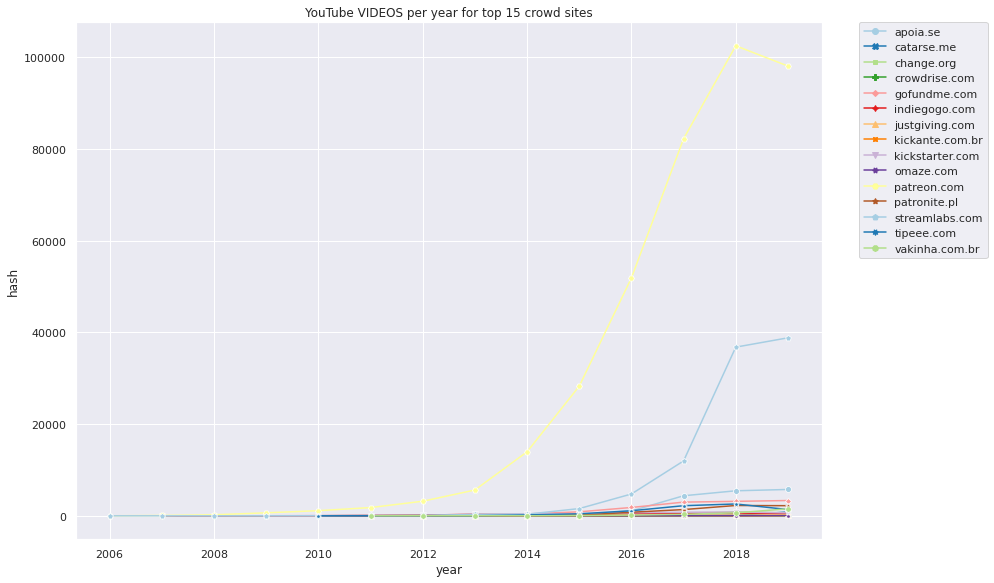

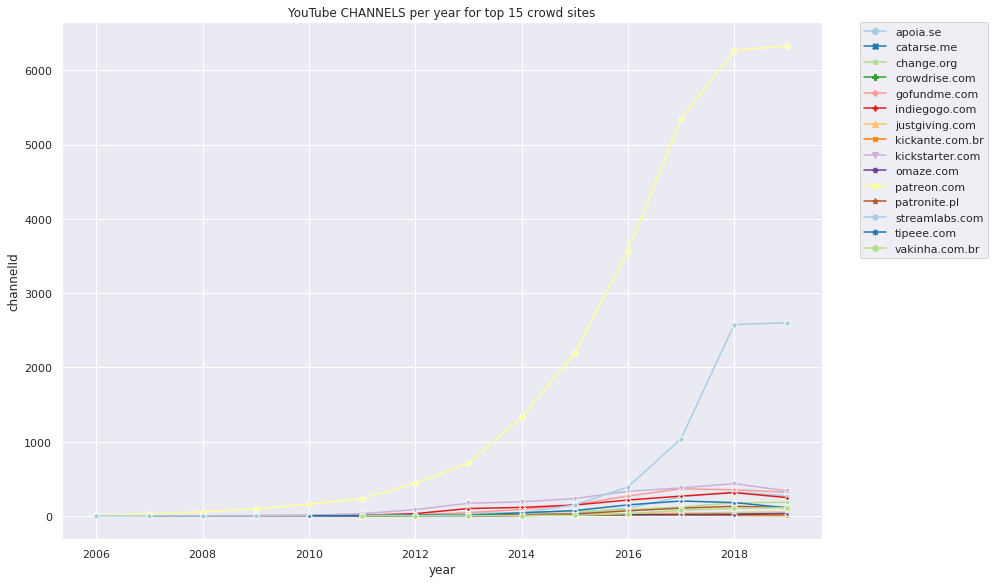

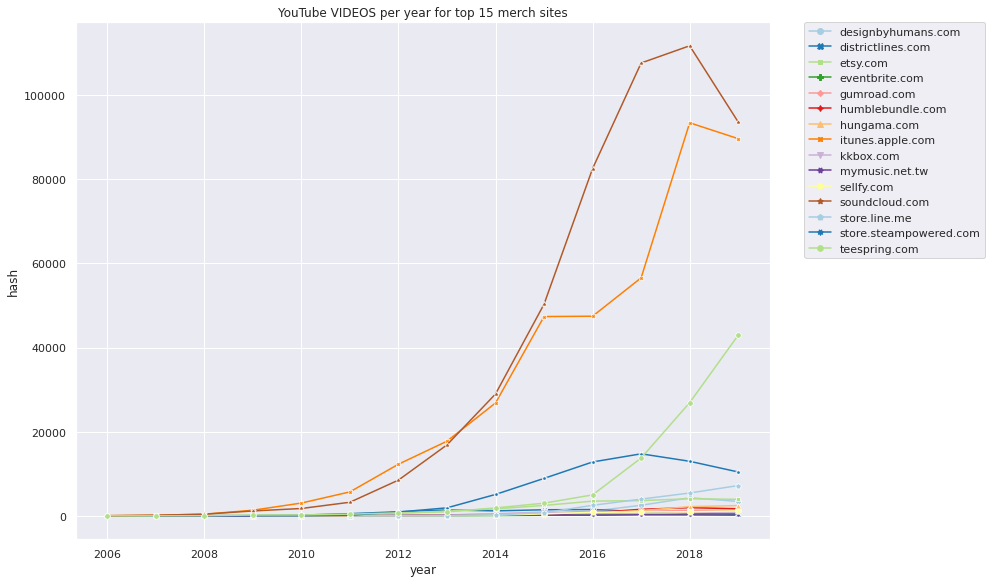

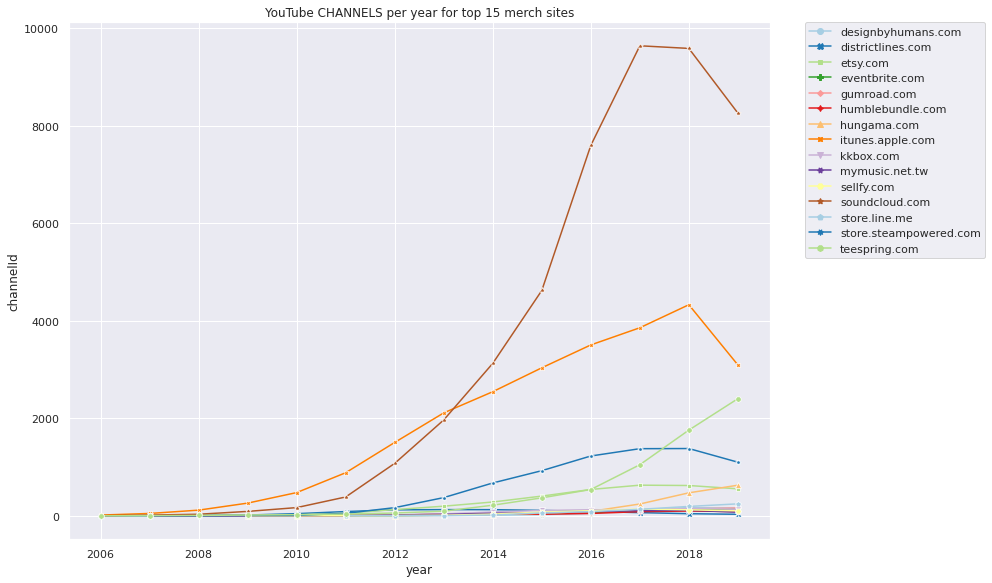

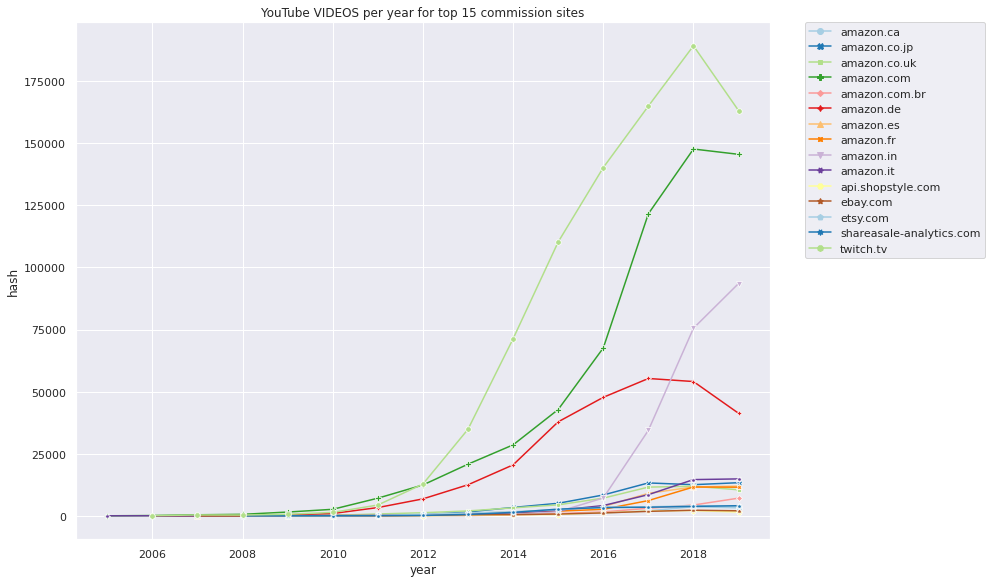

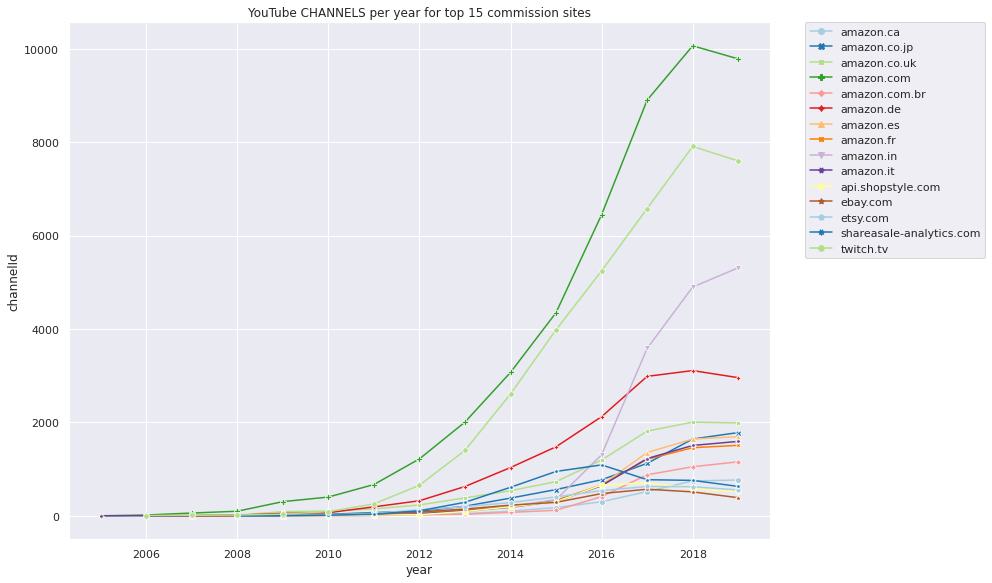

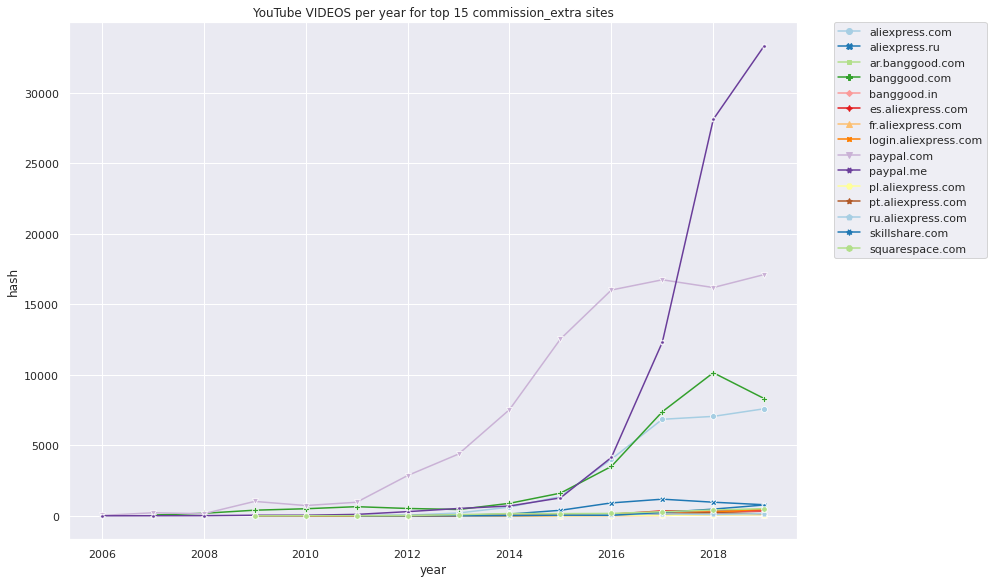

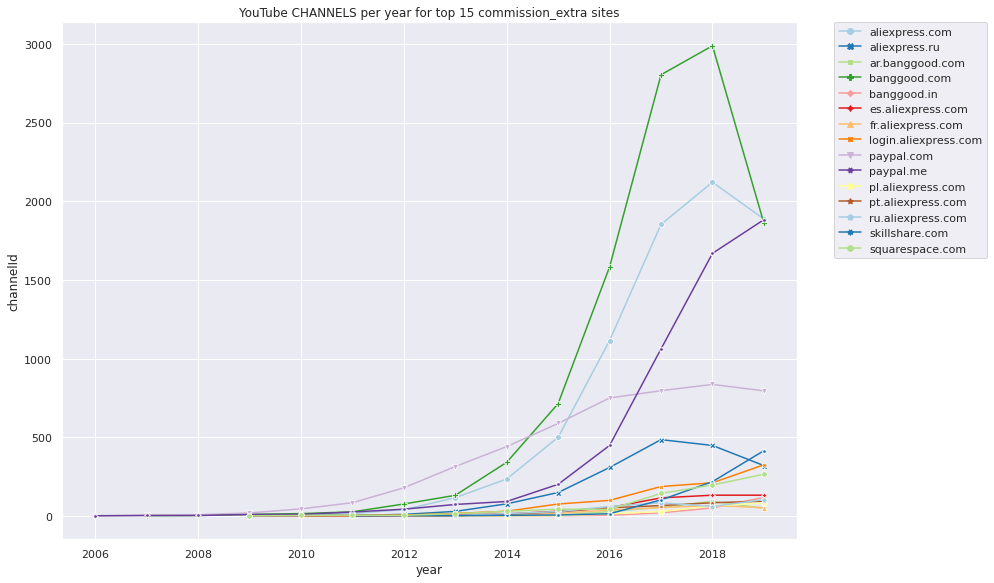

In [26]:
domain_stats = {}
for type in ['crowd','merch','commission','commission_extra']:

    ''' Describe '''
    domain_stats[type] = pd_url_data[['domain','channelCountForDomain','videoCountForDomain','channelDivVideoForDomain']][pd_url_data[type]==True].drop_duplicates()

    # print header
    print("%s domain count" % type)
    if type == "commission" or type == "commission_extra":
        print(domain_stats[type][domain_stats[type].isna().any(axis=1)])
        domain_stats[type]=domain_stats[type].dropna()
    # print most used TYPE domains
    domain_stats[type]['channelCountForDomain'] = domain_stats[type]['channelCountForDomain'].astype(int)
    domain_stats[type]['videoCountForDomain'] = domain_stats[type]['videoCountForDomain'].astype(int)

    with pd.option_context('display.precision', 3):
        display(domain_stats[type].sort_values(by=['channelCountForDomain','channelDivVideoForDomain'],ascending=False).head(limit).style.hide_index())
        print("\n")
        # print TYPE domain stats
        print("%s domain stats" % type)
        print(domain_stats[type].describe())
        print("\n")

    ''' Graph '''

    # filter pd_url_data to only retain info for rows with TYPE domain
    filtered = {}
    filtered[type] = pd_url_data[pd_url_data[type]==True]

    # limit data by top overall TYPE domain for graph
    top_domains = {}
    top_domains[type] = domain_stats[type].sort_values(by="channelCountForDomain",ascending=False)['domain'][0:limit]
    filtered_limited = {}
    filtered_limited[type] = filtered[type][filtered[type]['domain'].isin(top_domains[type])==True]

    # get number of unique domains for color palette in graph 
    num_domains = {}
    num_domains[type] = len(filtered_limited[type]['domain'].unique())
    color_palette = {}
    color_palette[type] = sns.color_palette("Paired",n_colors=num_domains[type])

    # count videos by TYPE domain and year
    filtered_limited_count = {}
    filtered_limited_count[type] = filtered_limited[type].groupby(["domain","year"])['hash'].nunique()
    filtered_limited_count[type] = filtered_limited_count[type].to_frame()
    filtered_limited_count[type].reset_index(inplace=True)
    
    # plot rise of TYPE sites, for videos per year
    plt.figure()
    sns.lineplot(x="year", y="hash", hue="domain", style="domain", palette = color_palette[type], markers=True, dashes=False, data=filtered_limited_count[type])
    plt.title("YouTube VIDEOS per year for top %s %s sites" % (limit,type))
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.tight_layout()

    # count channels by TYPE domain and year
    filtered_limited_count = {}
    filtered_limited_count[type] = filtered_limited[type].groupby(["domain","year"])['channelId'].nunique()
    filtered_limited_count[type] = filtered_limited_count[type].to_frame()
    filtered_limited_count[type].reset_index(inplace=True)

    # plot rise of TYPE sites, for channels per year
    plt.figure()
    sns.lineplot(x="year", y="channelId", hue="domain", style="domain", palette = color_palette[type], markers=True, dashes=False, data=filtered_limited_count[type])
    plt.title("YouTube CHANNELS per year for top %s %s sites" % (limit,type))
    plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
    plt.tight_layout()


## @todo

* Work on the referral list
   * √ Observations
      * √ not all monetization sites are part of our list getshirts.de
      * √ Stuff definitely missing on our lists: getshirts.de, amazon.{tld}, banggood, aliexpress, skillshare, …
   * √ Get 1000 domains of all URLs (overall and based on channel)
      * √ Already qualify as crowd, merch, commission
      * Continue the rest of the sites and see whether they should be included or added to (other) list via emergent (grounded theory) coding
   * √ match on host (instead of domain)
* Overall observations
   * √ Background graph: number of URLs per year
   * √ Make RankFlow of top domains per year
   * √ Add diversity for Domains, top deep links
   * √ How many domains for 80% coverage?
   * √ Diversity count in top host domain list + add whether it was in a partner program
   * √ Where are squarespace and dbrand -> added to commission_extra so they'll show up in stats and graphs at the end
   * √ diversity times 100, for percentage

* Breakdowns
   * subscriber / viewer tier (monetization categories)
   * language & locale (domains, e.g. top domains per locale)
   * category (channel & video)
   * year

Channel data set
* Fuse this with channels data set. Finding a way to use the URLs to characterize channels.
   * Channel categories. What hasn't been done at all in the last paper is looking at video categories. That may be done interestingly. Monetization per channel category. Channel classification is not done by video creators. 
	   * b = DataFrame(a.var1.str.split('|').tolist(), index=a.var2).stack()
	   * b = b.reset_index()[[0, 'var2']] # var1 variable is currently labeled 0
	   * b.columns = ['var1', 'var2'] # renaming var1
   * Merch and monetization per channel. When did they introduce this?
   * Whether channels changed merch or crowd-financing, giving that they not backport.
* Compare channel categories vs video categories. (But we need to import mysql database.) Is gonna be important when looking at descriptions and tags and such.
* Think of categories in terms of scatter plots. E.g. crowd funding vs merch and category. Size is number of videos.
* Via topic and/or video categories. E.g. gaming may have a very different URL profile then news/politics. 
* Merch stores with particular topical affinity (e.g. alt-right channels use store X) - alternative ways of classifying youtube. Otherway around: categories that are more suited to crowd-funding than others.

Alternative modes of classification? 
* For a channel we have channel description, keywords, all video titles and keywords. Run as a topic model.
* Video categories are unique and chosen by uploaders
* Channel category column can have several channels, is assigned done automatically by YouTube
* (channels have keywords too, which are much more descriptive. But long-tail, language specific)

Later
* Why are there ⅓ of URLs going to youtube.com and what do they link to (videos, channels?) Are they building a network, just like featuring or subscribing?
* Is the presence of other platforms a sign of cross-platform activity?
* Look into the means of production, e.g. free audio
* what kind of channels linked to the academic publishers?
* look into what's missing. The "(note-)book" of the dead.
	* https://www.youtube.com/error?src=404
	* unacademy.com/unavailable
* graphs, instead of absolute numbers, divide into number of videos per year
* Patreon pledgers, crowd-funding sites/pledges.
* Collect ASINs. How many different products are being advertised (most popular producst - # videos, #views; youtube as amazon catalogue).
* Each URL may afford something for analysis.
* Cross-language analysis. (Videos have language, channels have country flag). 